#Document Clustering with Python

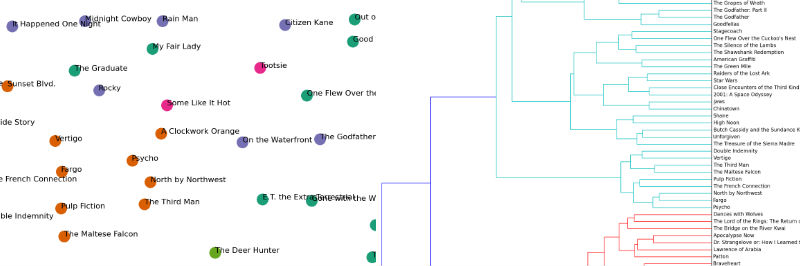

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopsis of the top 100 films of all time (per an IMDB list).

##Contents

In [2]:
!pip install mpld3

     |████████████████████████████████| 890kB 4.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.2-cp36-none-any.whl size=200618 sha256=235a408416428652a4c2958d306078f24ff7e2b6a0ba7b9c85192502537bf9e7
  Stored in directory: /root/.cache/pip/wheels/21/73/06/ea4b85609301850b1289a282852d92e22fcbf7a250ed5f547f
Successfully built mpld3


<ul>
<li>Stopwords, stemming, and tokenization
<li>Tf-idf and document similarity
<li>K-means clustering
<li>Multidimensional scaling
<li>Visualizing document clusters
</ul>

But first, I import everything I am going to need up front

In [3]:
#!pip install mpld3
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd /content/drive/MyDrive/MSDS-20/After Mid content/IR/Lecture 9/Tutorial 3

/content/drive/MyDrive/MSDS-20/After Mid content/IR/Lecture 9/Tutorial 3


#Stopwords, stemming, and tokenizing

In [12]:
#import three lists: titles, links and wikipedia synopsis
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopsis_wiki = open('synopsis_list_wiki.txt').read().split('\n BREAKS HERE')
synopsis_wiki = synopsis_wiki[:100]

synopsis_clean_wiki = []
for text in synopsis_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopsis_clean_wiki.append(text)

synopsis_wiki = synopsis_clean_wiki
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopsis_wiki)) + ' synopsis')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopsis
100 genres


In [14]:
synopsis_imdb = open('synopsis_list_imdb.txt').read().split('\n BREAKS HERE')
synopsis_imdb = synopsis_imdb[:100]

synopsis_clean_imdb = []

for text in synopsis_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopsis_clean_imdb.append(text)

synopsis_imdb = synopsis_clean_imdb

In [15]:
synopsis = []

for i in range(len(synopsis_wiki)):
    item = synopsis_wiki[i] + synopsis_imdb[i]
    synopsis.append(item)

In [16]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopsis. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [17]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>



In [18]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

##Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopsis* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopsis)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopsis use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams] (http://en.wikipedia.org/wiki/N-gram)
</ul>

In [19]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(synopsis)

print(tfidf_matrix.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(100, 563)


In [32]:
terms = tfidf_vectorizer.get_feature_names()

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [35]:
print(tfidf_matrix)

  (0, 4)	0.015840237403117192
  (0, 548)	0.01612420215693917
  (0, 87)	0.013158145917863982
  (0, 168)	0.01127492073118682
  (0, 208)	0.047520712209351584
  (0, 554)	0.015840237403117192
  (0, 427)	0.08485730621728925
  (0, 1)	0.046705079955494354
  (0, 343)	0.06022813901532093
  (0, 108)	0.012147386431826087
  (0, 287)	0.015840237403117192
  (0, 299)	0.013534028158239696
  (0, 306)	0.009010032167901243
  (0, 417)	0.015307582752631105
  (0, 37)	0.01184313106771756
  (0, 15)	0.01334332279941062
  (0, 222)	0.010753148800711149
  (0, 446)	0.013158145917863982
  (0, 437)	0.008289477056589938
  (0, 24)	0.013730602286522562
  (0, 497)	0.016421379232122783
  (0, 82)	0.012305126670905985
  (0, 483)	0.02916724306696112
  (0, 169)	0.0252655923822052
  (0, 200)	0.015568359985164785
  :	:
  (99, 383)	0.08619640541457027
  (99, 358)	0.07672891325500265
  (99, 177)	0.20333482818614418
  (99, 368)	0.09393190975382117
  (99, 215)	0.13192312316278199
  (99, 438)	0.06821489514982466
  (99, 283)	0.335609

In [38]:
print('Cosine Similarity : \n',dist)

Cosine Similarity : 
 [[ 0.00000000e+00  8.00539634e-01  7.62813109e-01 ...  6.41312416e-01
   6.70578229e-01  8.23926244e-01]
 [ 8.00539634e-01 -2.22044605e-16  7.33477850e-01 ...  7.33117814e-01
   7.71609239e-01  8.92974798e-01]
 [ 7.62813109e-01  7.33477850e-01  0.00000000e+00 ...  7.23806699e-01
   7.49489708e-01  8.58673233e-01]
 ...
 [ 6.41312416e-01  7.33117814e-01  7.23806699e-01 ...  0.00000000e+00
   4.50879024e-01  9.17464687e-01]
 [ 6.70578229e-01  7.71609239e-01  7.49489708e-01 ...  4.50879024e-01
   2.22044605e-16  8.68599864e-01]
 [ 8.23926244e-01  8.92974798e-01  8.58673233e-01 ...  9.17464687e-01
   8.68599864e-01 -2.22044605e-16]]


#K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopsis. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

In [39]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters = num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [40]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')

clusters = km.labels_.tolist()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [42]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopsis, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [43]:
frame

,rank,title,cluster,genre
3,0,The Godfather,3,"[u' Crime', u' Drama']"
3,1,The Shawshank Redemption,3,"[u' Crime', u' Drama']"
1,2,Schindler's List,1,"[u' Biography', u' Drama', u' History']"
0,3,Raging Bull,0,"[u' Biography', u' Drama', u' Sport']"
3,4,Casablanca,3,"[u' Drama', u' Romance', u' War']"
...,...,...,...,...
3,95,Rebel Without a Cause,3,[u' Drama']
3,96,Rear Window,3,"[u' Mystery', u' Thriller']"
3,97,The Third Man,3,"[u' Film-Noir', u' Mystery', u' Thriller']"
3,98,North by Northwest,3,"[u' Mystery', u' Thriller']"


In [44]:
frame['cluster'].value_counts()

3    41
1    28
4    14
0    11
2     6
Name: cluster, dtype: int64

In [45]:
grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    47.272727
1    50.642857
2    52.833333
3    51.292683
4    42.285714
Name: rank, dtype: float64

#Multidimensional scaling

In [46]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

##Visualizing document clusters

In [47]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

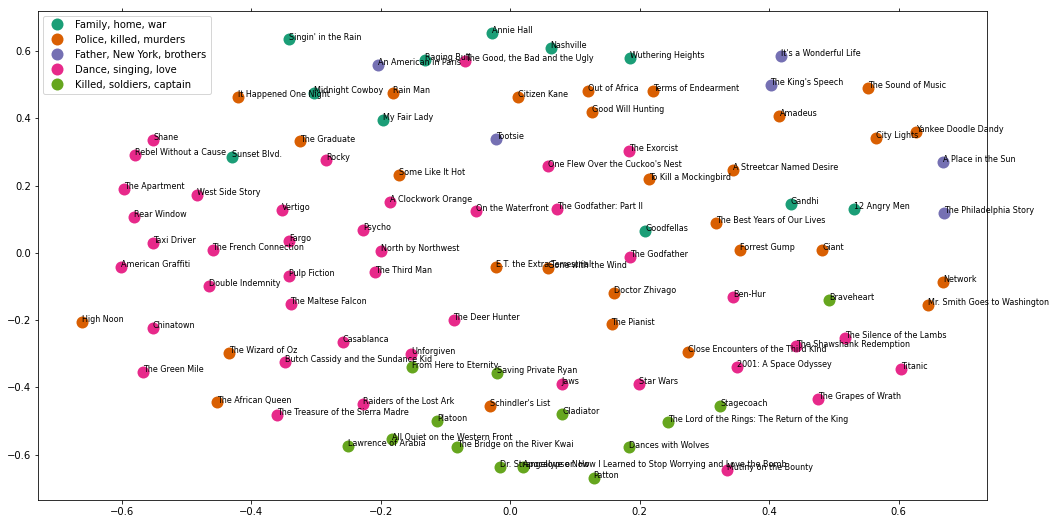

In [49]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot
plt.close()
#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)